In [396]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, quantile_transform
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [397]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/Predictive Modelling | MBAN 5110 U /Hackathon/Updated_XYZ_Sportswear_Orders_Dataset.csv')

In [398]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Value per Item
0,01.01.2009,18.02.2009,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,East,33.733750
1,01.01.2009,10.02.2009,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,West,85.170000
2,01.01.2009,17.01.2009,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,West,8.727143
3,03.01.2009,28.01.2009,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,North,41.863333
4,03.01.2009,18.01.2009,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,West,30.666000


In [399]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')
df['Order Month'] = df['Order Date'].dt.month
df['Order Year'] = df['Order Date'].dt.year
df['Delivery Month'] = df['Requested Delivery Date'].dt.month
df['Delivery Year'] = df['Requested Delivery Date'].dt.year
monthly_orders = df.groupby(['Order Year', 'Order Month']).agg({'Value': 'sum'}).reset_index()
monthly_orders = monthly_orders.sort_values(by=['Order Year', 'Order Month'])

def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'


df['Season'] = df['Order Month'].apply(month_to_season)
df['Year-Season'] = df['Order Year'].astype(str) + '-' + df['Season']

year_season_orders = df.groupby('Year-Season').agg({'Value': 'sum'}).reset_index()

year_season_orders['Year-Season'] = pd.Categorical(year_season_orders['Year-Season'], categories=sorted(df['Year-Season'].unique()), ordered=True)
year_season_orders = year_season_orders.sort_values('Year-Season')
df['Lead Time'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days

print(df[['Order Date', 'Requested Delivery Date', 'Lead Time']].head())

df['Lead Time'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days
df['Value/Item'] = df['Value']/df['Items']
df['Customer_ID'] = df['Customer Country Code'] + '-' + df['Route']


df['Season_Num'] = df['Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})

product_dummies = pd.get_dummies(df['Product Code'])
df = pd.concat([df, product_dummies], axis=1)

df['advanced_order'] = (df['Lead Time'] >= 30).astype(int)

df.head()

  Order Date Requested Delivery Date  Lead Time
0 2009-01-01              2009-02-18         48
1 2009-01-01              2009-02-10         40
2 2009-01-01              2009-01-17         16
3 2009-01-03              2009-01-28         25
4 2009-01-03              2009-01-18         15


,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,...,Year-Season,Lead Time,Value/Item,Customer_ID,Season_Num,PK001,PK002,PK003,PK004,advanced_order
0,2009-01-01,2009-02-18,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,...,2009-Winter,48,33.733750,DE-East,1,0,0,1,0,1
1,2009-01-01,2009-02-10,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,...,2009-Winter,40,85.170000,FR-West,1,1,0,0,0,1
2,2009-01-01,2009-01-17,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,...,2009-Winter,16,8.727143,ES-West,1,0,1,0,0,0
3,2009-01-03,2009-01-28,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,...,2009-Winter,25,41.863333,IT-North,1,0,0,1,0,0
4,2009-01-03,2009-01-18,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,...,2009-Winter,15,30.666000,DE-West,1,0,0,0,1,0


In [400]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Description', 'Order Type', 'Customer Order Code',
       'Value', 'Currency', 'Items', 'Route', 'Value per Item', 'Order Month',
       'Order Year', 'Delivery Month', 'Delivery Year', 'Season',
       'Year-Season', 'Lead Time', 'Value/Item', 'Customer_ID', 'Season_Num',
       'PK001', 'PK002', 'PK003', 'PK004', 'advanced_order'],
      dtype='object')

In [401]:
total_items_per_season = df.groupby('Season_Num')['Items'].sum()
items_per_product_season = df.groupby(['Season_Num', 'Product Code'])['Items'].sum().reset_index()
merged_df = pd.merge(items_per_product_season, total_items_per_season, on='Season_Num', suffixes=('', '_Total'))

merged_df['Selection_Rate'] = merged_df['Items'] / merged_df['Items_Total']
selection_rate_dict = merged_df.set_index(['Season_Num', 'Product Code'])['Selection_Rate'].to_dict()

df['Avg_Season_Selection_Rate'] = df.apply(lambda row: selection_rate_dict.get((row['Season_Num'], row['Product Code'])), axis=1)

df.head()



,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,...,Lead Time,Value/Item,Customer_ID,Season_Num,PK001,PK002,PK003,PK004,advanced_order,Avg_Season_Selection_Rate
0,2009-01-01,2009-02-18,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,...,48,33.733750,DE-East,1,0,0,1,0,1,0.249896
1,2009-01-01,2009-02-10,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,...,40,85.170000,FR-West,1,1,0,0,0,1,0.272954
2,2009-01-01,2009-01-17,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,...,16,8.727143,ES-West,1,0,1,0,0,0,0.248027
3,2009-01-03,2009-01-28,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,...,25,41.863333,IT-North,1,0,0,1,0,0,0.249896
4,2009-01-03,2009-01-18,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,...,15,30.666000,DE-West,1,0,0,0,1,0,0.229123


In [402]:
df['Avg_Season_Selection_Rate'].unique()

array([0.24989614, 0.27295388, 0.24802659, 0.22912339, 0.22867822,
       0.24294937, 0.27353041, 0.254842  , 0.23615695, 0.27832783,
       0.27099377, 0.21452145, 0.21392424, 0.26146297, 0.25440883,
       0.27020396])

In [403]:
df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Product Code', 'Description', 'Order Type', 'Customer Order Code',
       'Value', 'Currency', 'Items', 'Route', 'Value per Item', 'Order Month',
       'Order Year', 'Delivery Month', 'Delivery Year', 'Season',
       'Year-Season', 'Lead Time', 'Value/Item', 'Customer_ID', 'Season_Num',
       'PK001', 'PK002', 'PK003', 'PK004', 'advanced_order',
       'Avg_Season_Selection_Rate'],
      dtype='object')

In [404]:
features = ['Season_Num', 'Order Year', 'Customer Country Code', 'Route', 'Order Month', 'Delivery Month', 'Delivery Year', 'Lead Time', 'Avg_Season_Selection_Rate', 'Items', 'Value', 'Value/Item', 'advanced_order']

X = df[features]
y = df['Product Code']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_features = ['Season_Num', 'Customer Country Code', 'Route', 'Order Year', 'Delivery Year', 'advanced_order']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['Lead Time', 'Avg_Season_Selection_Rate', 'Items', 'Value', 'Value/Item']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [405]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

In [406]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)
model.fit(X_train, y_train)

y_pred_probs = model.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

Log Loss: 1.3921


In [407]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

probabilities = model.predict_proba(X)

prob_cols = [f'prob_{code}' for code in le.classes_]
df_probs = pd.DataFrame(probabilities, columns=prob_cols, index=X.index)

df_with_probs = df.join(df_probs)

seasonal_choice_probabilities = df_with_probs.groupby('Season_Num')[prob_cols].mean()

print(seasonal_choice_probabilities)


Accuracy: 0.2619
            prob_PK001  prob_PK002  prob_PK003  prob_PK004
Season_Num                                                
1             0.257080    0.232399    0.256180    0.254341
2             0.270815    0.268277    0.237636    0.223272
3             0.228701    0.264388    0.220347    0.286565
4             0.254533    0.238087    0.260618    0.246761


In [408]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,...,Lead Time,Value/Item,Customer_ID,Season_Num,PK001,PK002,PK003,PK004,advanced_order,Avg_Season_Selection_Rate
0,2009-01-01,2009-02-18,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,...,48,33.733750,DE-East,1,0,0,1,0,1,0.249896
1,2009-01-01,2009-02-10,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,...,40,85.170000,FR-West,1,1,0,0,0,1,0.272954
2,2009-01-01,2009-01-17,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,...,16,8.727143,ES-West,1,0,1,0,0,0,0.248027
3,2009-01-03,2009-01-28,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,...,25,41.863333,IT-North,1,0,0,1,0,0,0.249896
4,2009-01-03,2009-01-18,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,...,15,30.666000,DE-West,1,0,0,0,1,0,0.229123


In [413]:
grouped_df = df.groupby(['advanced_order', 'Order Year', 'Order Month']).agg({'Items': 'sum'}).reset_index()


In [420]:
grouped_df['Month/Year'] = grouped_df['Order Year'].astype(str) + '-' + grouped_df['Order Month'].astype(str).str.zfill(2)


In [421]:
grouped_df.head(50)

,advanced_order,Order Year,Order Month,Items,Month/Year
0,0,2009,1,156,2009-01
1,0,2009,2,186,2009-02
2,0,2009,3,205,2009-03
3,0,2009,4,126,2009-04
4,0,2009,5,142,2009-05
5,0,2009,6,158,2009-06
6,0,2009,7,179,2009-07
7,0,2009,8,166,2009-08
8,0,2009,9,166,2009-09
9,0,2009,10,477,2009-10


<Axes: xlabel='Month/Year', ylabel='Items'>

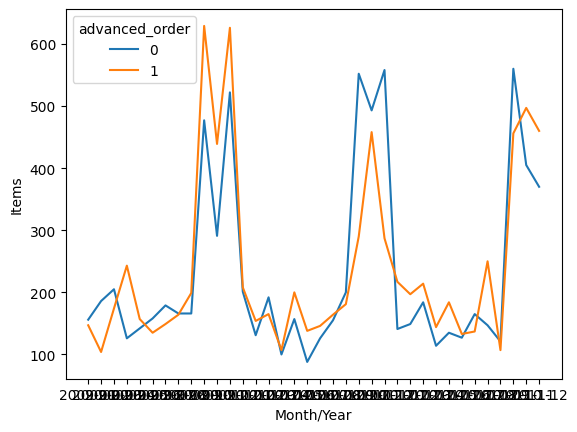

In [422]:
sns.lineplot(data=grouped_df, x='Month/Year', y='Items', hue='advanced_order')